In [25]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import datetime

import numpy as np
from time import time

from sklearn import metrics
from sklearn import preprocessing

from sklearn.datasets.species_distributions import construct_grids
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')



def parse_location(loc):
    loc = loc.strip("()").split(',')
    lat = loc[0].strip()
    long = loc[1].strip()
    return float(lat), float(long)

def classification_report(y_true, y_pred, verbose=False):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    accuracy_score = metrics.accuracy_score(y_true, y_pred)
    recall_score = metrics.recall_score(y_true, y_pred)
    precision_score = metrics.precision_score(y_true, y_pred)
    f1_score = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    if verbose:
        print('confusion_matrix')
        print(confusion_matrix)
        print('accuracy_score', accuracy_score)
        print('recall_score', recall_score)
        print('precision_score', precision_score)
        print('f1_score', f1_score)
        print('auc', auc)
    
    return confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, auc
    

def get_scaler(column):
    X = np.array(column).reshape(column.shape[0], 1)
    return preprocessing.MinMaxScaler().fit(column)

def scale(scaler, column):
    X = np.array(column).reshape(column.shape[0], 1)
    return scaler.transform(X)

In [26]:
%time df = pd.read_csv('features_temporal_full_year_with_weather.tsv', sep='\t', parse_dates=['timestamp'], index_col='timestamp')
df.head()

CPU times: user 352 ms, sys: 12 ms, total: 364 ms
Wall time: 367 ms


,cell_range,crime_freq,yelp_freq,police_freq,lat,long,police_factor,yelp_factor,prev_day_crime_freq,prev_7_days_crime_freq,PRCP,SNOW,TMAX,TMIN
timestamp,,,,,,,,,,,,,,
2006-01-01,"((41.5487, -88.3713), (41.577144999999994, -88...",0,0,0,41.562922,-88.339368,4.175852e-24,0.069791,NaN,NaN,0.8,0,7.2,-3.3
2006-01-01,"((41.5487, -88.307435), (41.577144999999994, -...",0,0,0,41.562922,-88.275503,1.625700e-19,1.140434,NaN,NaN,0.8,0,7.2,-3.3
2006-01-01,"((41.5487, -88.24357), (41.577144999999994, -8...",0,0,0,41.562922,-88.211637,2.394447e-15,7.117705,NaN,NaN,0.8,0,7.2,-3.3
2006-01-01,"((41.5487, -88.179705), (41.577144999999994, -...",0,0,0,41.562922,-88.147773,1.284389e-11,15.734032,NaN,NaN,0.8,0,7.2,-3.3
2006-01-01,"((41.5487, -88.11584), (41.577144999999994, -8...",0,0,0,41.562922,-88.083908,2.434802e-08,11.941449,NaN,NaN,0.8,0,7.2,-3.3


In [27]:
df.columns

Index(['cell_range', 'crime_freq', 'yelp_freq', 'police_freq', 'lat', 'long',
       'police_factor', 'yelp_factor', 'prev_day_crime_freq',
       'prev_7_days_crime_freq', 'PRCP', 'SNOW', 'TMAX', 'TMIN'],
      dtype='object')

In [28]:
df.dropna(inplace=True)

# Training Test Defined

In [34]:
def _classifier_name(classifier):
    
    name = type(classifier).__name__
    if name == 'SVC':
        return classifier.kernel + ' ' + name
    return name
    
def train_and_test(X_train, X_test, y_train, y_test, features=None, verbose=False, random_state = 4, classifiers=None):
    def scale_columns(train, test, column_names):
        for column_name in column_names:
            scaler = get_scaler(train[column_name])
            train[column_name] = scale(scaler, train[column_name])
            test[column_name] = scale(scaler, test[column_name])
    
    scale_columns(X_train, X_test, features)
    
    test = X_test.copy() 
    test['label'] = y_test
    
    X_train = X_train[features]
    X_test = X_test[features]
    
    # class_weight = {
    #     1: 10,
    #     0: 1
    # }
    class_weight = 'balanced'
    
    training_size = len(X_train.index.unique())
    
    if classifiers is None:
        classifiers = [
            DecisionTreeClassifier(max_depth=5, class_weight=class_weight, random_state=random_state),
            RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight=class_weight, random_state=random_state),
        ]
        
    report = []
    for classifier in classifiers:
        if verbose:
            print('\n')
            print('#'*10, type(classifier).__name__, '#'*10)
            
        selector = RFE(classifier, 1, step=1)
        selector = selector.fit(X_train, y_train)
        print(pd.DataFrame({
                'ranking': selector.ranking_,
                'features': features
            }))
        

# time series split using cross validation time series

In [35]:
def test_models(features, splits=2, verbose=False, classifiers=None):
    if verbose:
        print()
        print('#'*100)
        print('#'*10 + str(features) + '#'*10)
        print('#'*100)
        print()

    X = df
    y = df.crime_freq.apply(lambda x: 1 if x > 0 else 0)
    
    tscv = TimeSeriesSplit(n_splits=splits)
    
    frames = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        train_start_date, train_end_date = X_train.index[0].date(), X_train.index[-1].date()
        test_start_date, test_end_date = X_test.index[0].date(), X_test.index[-1].date()
        training_size = len(X_train.index.unique())
        
        if verbose:
            print()
            print('>'*100)
            print("Training: ", str(train_start_date), "to" , str(train_end_date))
            print("Test: ", str(test_start_date), "to" , str(test_end_date))
            print('>'*100)
            print()
        
        train_and_test(X_train, X_test, y_train, y_test, features=features, verbose=verbose, classifiers=classifiers)
        
    return

In [36]:
class_weight="balanced"
random_state=4

classifiers = [
#         KNeighborsClassifier(n_neighbors=5),
#         SVC(kernel="linear", C=0.025, class_weight=class_weight, random_state=random_state),
#         SVC(gamma=2, C=1, class_weight=class_weight, random_state=random_state),
#         GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        DecisionTreeClassifier(max_depth=5, class_weight=class_weight, random_state=random_state),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight=class_weight, random_state=random_state),
#         MLPClassifier(alpha=1, random_state=random_state),
#         AdaBoostClassifier(random_state=random_state),
#         GaussianNB(),
#         QuadraticDiscriminantAnalysis()
        ]

features = [
    'PRCP', 
    'SNOW', 
    'TMAX', 
    'TMIN',
#     'crime_freq', 
#      'yelp_freq', 
#      'police_freq', 
     'police_factor', 
#     'crime_factor', 
    'yelp_factor', 
    'prev_day_crime_freq',
    'prev_7_days_crime_freq'
]

test_models(features, classifiers=classifiers, splits=2, verbose=True)


####################################################################################################
##########['PRCP', 'SNOW', 'TMAX', 'TMIN', 'police_factor', 'yelp_factor', 'prev_day_crime_freq', 'prev_7_days_crime_freq']##########
####################################################################################################


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Training:  2006-01-02 to 2006-05-03
Test:  2006-05-03 to 2006-09-01
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>



########## DecisionTreeClassifier ##########
                 features  ranking
0                    PRCP        4
1                    SNOW        8
2                    TMAX        5
3                    TMIN        7
4           police_factor        2
5             yelp_factor        3
6     prev_day_crime_freq        6
7  prev_7_days_crime_freq        1


########## RandomForestCla

In [23]:
report_df
# report_df.to_csv('Jan_2_split_classification_report.tsv', sep='\t', index=False)

NameError: name 'report_df' is not defined

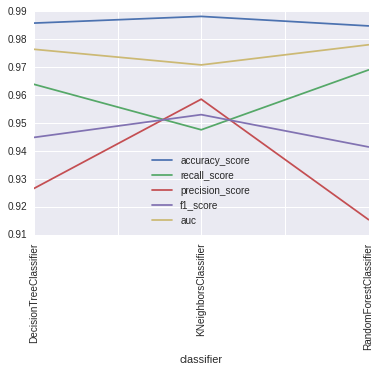

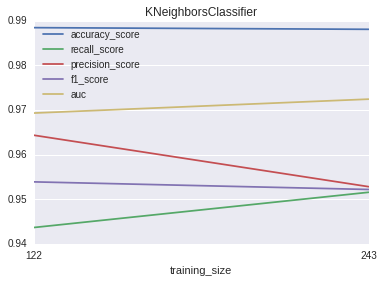

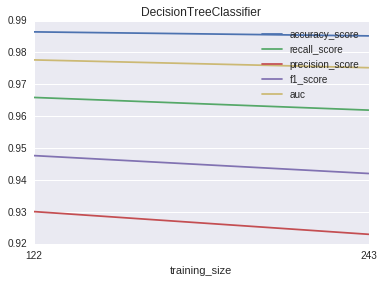

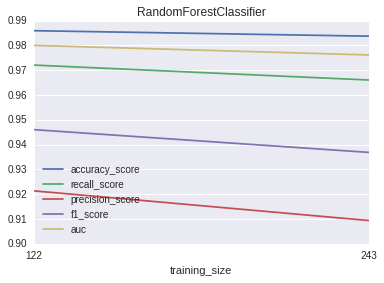

In [316]:
classifiers = [
        KNeighborsClassifier(n_neighbors=5),
#         SVC(kernel="linear", C=0.025, class_weight=class_weight, random_state=random_state),
#         SVC(gamma=2, C=1, class_weight=class_weight, random_state=random_state),
#         GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
        DecisionTreeClassifier(max_depth=5, class_weight=class_weight, random_state=random_state),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, class_weight=class_weight, random_state=random_state),
#         MLPClassifier(alpha=1, random_state=random_state),
#         AdaBoostClassifier(random_state=random_state),
#         GaussianNB(),
#         QuadraticDiscriminantAnalysis()
        ]

features = [
#     'PRCP', 
#     'SNOW', 
#     'TMAX', 
#     'TMIN',
#     'crime_freq', 
#      'yelp_freq', 
#      'police_freq', 
     'police_factor', 
#     'crime_factor', 
    'yelp_factor', 
    'prev_day_crime_freq',
#     'prev_7_days_crime_freq'
]

report_df = test_models(features, classifiers=classifiers, splits=2, verbose=False)
ax = report_df[['classifier', 
            'accuracy_score', 
            'recall_score', 
            'precision_score', 
            'f1_score', 
            'auc']].groupby(by=['classifier']).mean().plot(rot=90)

for classifier in report_df.classifier.unique():
    ax = report_df[report_df.classifier == classifier].groupby(by=['training_size']).mean().plot(title=classifier)
    ax.xaxis.set_ticks(report_df.training_size.unique())
